In [2]:
#Importing OpenAI gym package and MuJoCo engine
#import gym


import tensorflow as tf
from tf_agents.environments import suite_gym
from tf_agents.environments.wrappers import ActionDiscretizeWrapper
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.networks.q_network import QNetwork
from tf_agents.agents.dqn.dqn_agent import DqnAgent
from tf_agents.environments import tf_py_environment
from tensorflow import keras
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import time
import os
from collections import deque
import matplotlib.animation as animation

replay_memory = deque(maxlen=2000)

num_steps = 1000
num_iters = 100
max_epsilon = 50


env_name = 'InvertedPendulum-v2'
env = suite_gym.load(env_name)
env = ActionDiscretizeWrapper(env, num_actions=5)
tf_env = tf_py_environment.TFPyEnvironment(env)


#train_py_env = suite_gym.load("InvertedPendulum-v2")
#train_py_env = ActionDiscretizeWrapper(train_py_env, num_actions=5)
#train_env = tf_py_environment.TFPyEnvironment(train_py_env)

#eval_py_env  = suite_gym.load("InvertedPendulum-v2")
#eval_py_env = ActionDiscretizeWrapper(eval_py_env, num_actions=5)
#eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Version site tensorflow

#num_iterations = 200 # @param {type:"integer"}

#initial_collect_steps = 100  # @param {type:"integer"}
#collect_steps_per_iteration =   1# @param {type:"integer"}
#replay_buffer_max_length = 100000  # @param {type:"integer"}

#batch_size = 64  # @param {type:"integer"}
#learning_rate = 1e-3  # @param {type:"number"}
#log_interval = 200  # @param {type:"integer"}

#num_eval_episodes = 10  # @param {type:"integer"}
#eval_interval = 1000  # @param {type:"integer"}

In [5]:
from tf_agents.specs import tensor_spec
from tf_agents.networks import sequential
from tf_agents.agents.dqn import dqn_agent
from tf_agents.utils import common

learning_rate = 1e-3

fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
    return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()


# Version livre

In [6]:
#Buffer
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=100000) # reduce if OOM error

replay_buffer_observer = replay_buffer.add_batch

In [7]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

In [9]:
#Metric
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

from tf_agents.eval.metric_utils import log_metrics
import logging
logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


In [32]:
#buffer
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=100000) # reduce if OOM error

replay_buffer_observer = replay_buffer.add_batch

In [33]:
#collect
update_period = 4

from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period) # collect 4 steps for each training iteration

from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
                                        tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=10000) # <=> 80,000 ALE frames
final_time_step, final_policy_state = init_driver.run()

10000/20000

In [34]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3).prefetch(3)

from tf_agents.utils.common import function

#collect_driver.run = function(collect_driver.run)
#agent.train = function(agent.train)

def train_agent(n_iterations):

    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(
            iteration, train_loss.loss.numpy()), end="")
        if iteration % 1000 == 0:
            log_metrics(train_metrics)
            


In [35]:
train_agent(n_iterations=500)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
INFO:absl: 
		 NumberOfEpisodes = 4
		 EnvironmentSteps = 12
		 AverageReturn = 3.0
		 AverageEpisodeLength = 2.5


499 loss:31.47085

In [42]:

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

frames = []
def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, ShowProgress(1000)],
    num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()

plot_animation(frames).save("test.mp4")

900/1000

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 25.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y test.mp4


1000/1000

In [41]:
import PIL

image_path = "test.mp4"
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:150]]
frame_images[0].save(image_path, format='MP4',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)

KeyError: 'MP4'

# Version site tensorflow

In [3]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]





In [4]:
#tampon relecture

import reverb
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils

table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)


[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpdac0g9i0.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmpdac0g9i0
[reverb/cc/platform/default/server.cc:71] Started replay server on port 45375


In [11]:
# Collecte de données

from tf_agents.drivers import py_driver
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy


random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())


py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(env.reset())

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.00265241, -0.00396902, -0.00252635, -0.00246298]),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})


In [14]:
# Formation de l'agent

time_step = env.reset()
try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    train_env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):
    # Collect a few steps and save to the replay buffer.
    time_step, _ = collect_driver.run(time_step)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)
        

ValueError: Only supports batched time steps with a single batch dimension

In [ ]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

# OLD DONT WORK LAYER INIT AGENTS

In [27]:
## OLD BUT DON T WORK
## OLD BUT DON T WORK
## OLD BUT DON T WORK
## OLD BUT DON T WORK
## OLD BUT DON T WORK

preprocessing_layer = keras.layers.Lambda(
                          lambda obs: tf.cast(obs, np.float32) / 255.)
conv_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params=[512]

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)

train_step = tf.Variable(0)
update_period = 4 # run a training step every 4 collect steps
optimizer = keras.optimizers.RMSprop(learning_rate=2.5e-4, rho=0.95, momentum=0.0,
                                     epsilon=0.00001, centered=True)
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, # initial ε
    decay_steps=250000 // update_period, # <=> 1,000,000 ALE frames
    end_learning_rate=0.01) # final ε
agent = DqnAgent(tf_env.time_step_spec(),
                 tf_env.action_spec(),
                 q_network=q_net,
                 optimizer=optimizer,
                 target_update_period=2000, # <=> 32,000 ALE frames
                 td_errors_loss_fn=keras.losses.Huber(reduction="none"),
                 gamma=0.99, # discount factor
                 train_step_counter=train_step,
                 epsilon_greedy=lambda: epsilon_fn(train_step))
agent.initialize()

ValueError: Exception encountered when calling layer "EncodingNetwork" "                 f"(type EncodingNetwork).

Input 0 of layer "conv2d_6" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (1, 4)

Call arguments received by layer "EncodingNetwork" "                 f"(type EncodingNetwork):
  • observation=tf.Tensor(shape=(1, 4), dtype=float64)
  • step_type=tf.Tensor(shape=(1,), dtype=int32)
  • network_state=()
  • training=False
  In call to configurable 'DqnAgent' (<class 'tf_agents.agents.dqn.dqn_agent.DqnAgent'>)

In [17]:

env.seed(42)
env.reset()
renders = []
for _ in range(10):
    time_step = env.step(3) # LEFT
    im = ax.imshow(env.render(mode='rgb_array'), animated=True)
    renders.append([im, episode_text])

ani = animation.ArtistAnimation(fig, renders, interval=50, blit=True, repeat=False)
ani.save("test.mp4")

# Ancien

2022-09-23 12:33:57.733512: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/envs/railrl/lib/python3.7/site-packages/cv2/../../lib64:/mujoco/.mujoco/mujoco210/bin:/mujoco/.mujoco/mujoco200_linux/bin:/mujoco/.mujoco/mujoco200/bin:/mujoco/.mujoco/mjpro150/bin:/usr/local/nvidia/lib64:/usr/lib/x86_64-linux-gnu:/usr/lib/i386-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/root/.mujoco/mujoco210/bin
2022-09-23 12:33:57.733554: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-23 12:33:57.733573: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (7bf2a36b10a7): /proc/driver/nvidia/version does not exist
2022-09-23 12:33:57.733863: I tensorflow/core/pl

TypeError: tuple indices must be integers or slices, not NoneType

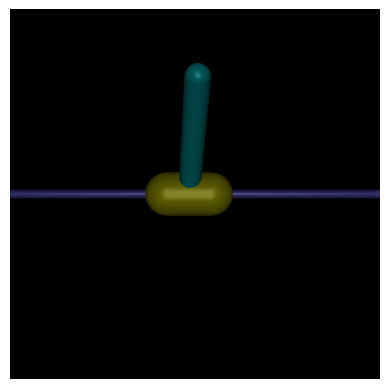

In [6]:

    
    
    
    
    
    
    
    
    
    
    
    
    
isDocker = os.environ.get("DOCKER_FLAG") == "1"
#isDocker = True


###Deep q-Learning
keras.backend.clear_session()

input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

liste_fibonnaci = [1,1]
actual_fibonnaci = liste_fibonnaci[-1]

def next_fibonnaci(liste):
    return liste[-1]+liste[-2]
    #usefull for rec video


def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info


batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
###



#env.seed(42)
#np.random.seed(42)
#tf.random.set_seed(42)

rewards = [] 
best_score = 0

obs = env.reset()

fig, ax = plt.subplots()
plt.axis("off")
renders = []
for episode in range(1, num_iters+1):
    obs = env.reset()
    #print("Itteration ", episode)
    is_record = False
    if episode == actual_fibonnaci:
        liste_fibonnaci.append(next_fibonnaci(liste_fibonnaci))
        actual_fibonnaci = liste_fibonnaci[-1]
        is_record = True
    for step in range(num_steps):
        epsilon = max(1 - episode / max_epsilon, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        
        if is_record:
            #ax.text(20,20, str(episode))
            episode_text = ax.text(20, 20, "Episode " + str(episode) + "  Step " + str(step))
            im = ax.imshow(env.render(mode='rgb_array'), animated=True)
            renders.append([im, episode_text])
            
        if done:
            break
    rewards.append(step) # Not shown in the book
    if step >= best_score: # Not shown
        best_weights = model.get_weights() # Not shown
        best_score = step # Not shown
        #print("\nNew best score: ", best_score)
    #print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    if episode > 50:
        training_step(batch_size)
    env.reset()
print("\nBest score: ", best_score)
env.close()


ani = animation.ArtistAnimation(fig, renders, interval=50, blit=True, repeat=False)
ani.save("mov.mp4")

plt.clf()
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()
plt.savefig("stats.png")
